In [1]:
import numpy as np
import scipy.signal as signal
from scipy.stats import skew as skewness
from scipy.stats import kurtosis as kurtosis_value
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import librosa 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2


In [2]:
dataset_audio = pd.read_csv("dataset\dataset heartbeat.csv") 
audio_paths = []
labels = []

for i in range(len(dataset_audio)):
    file_name = "dataset/training-a/wav new/" + dataset_audio['Data'][i] + ".wav"
    audio_paths.append(file_name)

    print(file_name)

    # labels.append(dataset_audio['Column2'][i])
    labels.append(dataset_audio['Label'][i])



dataset/training-a/wav new/a0001.wav
dataset/training-a/wav new/a0002.wav
dataset/training-a/wav new/a0003.wav
dataset/training-a/wav new/a0004.wav
dataset/training-a/wav new/a0005.wav
dataset/training-a/wav new/a0006.wav
dataset/training-a/wav new/a0007.wav
dataset/training-a/wav new/a0008.wav
dataset/training-a/wav new/a0009.wav
dataset/training-a/wav new/a0010.wav
dataset/training-a/wav new/a0011.wav
dataset/training-a/wav new/a0012.wav
dataset/training-a/wav new/a0013.wav
dataset/training-a/wav new/a0014.wav
dataset/training-a/wav new/a0015.wav
dataset/training-a/wav new/a0016.wav
dataset/training-a/wav new/a0017.wav
dataset/training-a/wav new/a0018.wav
dataset/training-a/wav new/a0019.wav
dataset/training-a/wav new/a0020.wav
dataset/training-a/wav new/a0021.wav
dataset/training-a/wav new/a0022.wav
dataset/training-a/wav new/a0023.wav
dataset/training-a/wav new/a0024.wav
dataset/training-a/wav new/a0025.wav
dataset/training-a/wav new/a0026.wav
dataset/training-a/wav new/a0027.wav
d

In [3]:
# Pra-pemrosesan audio dan pemotongan segmen
def preprocess_audio(audio_path, segment_length, overlap):
    audio, sr = librosa.load(audio_path, sr=None)
    audio_normalized = audio / np.max(np.abs(audio))  # Normalisasi amplitudo audio

    segments = []
    step = int(segment_length * (1 - overlap))
    for i in range(0, len(audio_normalized) - segment_length, step):
        segment = audio_normalized[i:i + segment_length]
        segments.append(segment)
    return segments


# Fungsi untuk menghitung fitur-fitur Hjorth
def hjorth_features(signal):
    diff1 = np.diff(signal)
    diff2 = np.diff(signal, 2)
    var_signal = np.var(signal)
    var_diff1 = np.var(diff1)
    var_diff2 = np.var(diff2)
    mobility = np.sqrt(var_diff1 / var_signal)
    complexity = np.sqrt(var_diff2 / var_diff1) / mobility if var_diff1 != 0 else 0
    return np.mean(signal), np.std(signal), mobility, complexity, np.mean(diff1), np.std(diff1), np.mean(diff2), np.std(diff2)


# Pra-pemrosesan audio dan ekstraksi fitur Hjorth
segment_length = 1000  # Panjang segmen suara (misalnya 1 detik)
overlap = 0.5  # Jumlah tumpang tindih antara segmen-suara
features = []


for audio_path in audio_paths:
    audio, sr = librosa.load(audio_path, sr=None)
    audio_normalized = audio / np.max(np.abs(audio))  # Normalisasi amplitudo audio
    mean, std, mobility, complexity, mean_diff1, std_diff1, mean_diff2, std_diff2 = hjorth_features(audio_normalized)
    features.append([mean, std, mobility, complexity, mean_diff1, std_diff1, mean_diff2, std_diff2])



features = np.array(features)
labels = np.array(labels)

# Melakukan label encoding pada label kelas
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)


# x_train = np.concatenate((normal_sounds, murmur_sounds))
# y_train = np.concatenate((normal_labels, murmur_labels))
x_train[5].shape

# Mengubah bentuk data menjadi 3 dimensi untuk RNN-LSTM (jumlah sampel, panjang setiap sampel, jumlah fitur)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train[5].shape


(1, 8)

Build LSTM RNN model ...
Epoch 1/100
11/11 [==============================] - 4s 46ms/step - loss: 0.6905 - accuracy: 0.5474 - val_loss: 0.6709 - val_accuracy: 0.7195
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6635 - accuracy: 0.7125 - val_loss: 0.6405 - val_accuracy: 0.7195
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6353 - accuracy: 0.7125 - val_loss: 0.6060 - val_accuracy: 0.7195
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.6077 - accuracy: 0.7125 - val_loss: 0.5731 - val_accuracy: 0.7195
Epoch 5/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5861 - accuracy: 0.7125 - val_loss: 0.5538 - val_accuracy: 0.7195
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5840 - accuracy: 0.7125 - val_loss: 0.5505 - val_accuracy: 0.7195
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5897 - accuracy: 0.7125 - val_loss: 0.5503 - val_accu

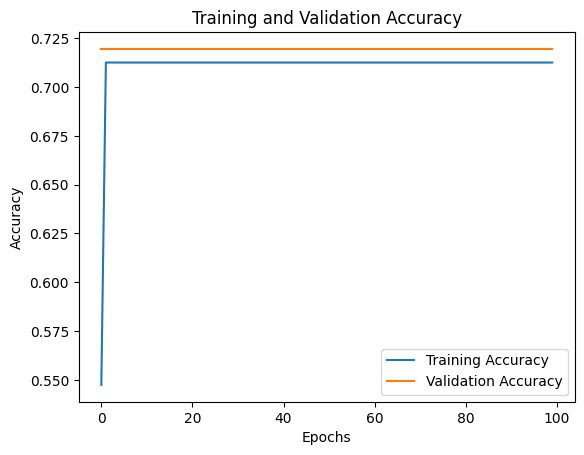

In [6]:
import matplotlib.pyplot as plt

print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True,input_shape = (1, 8)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(x_train, y_train, batch_size=32, epochs=100)
# Melakukan pelatihan model dan menyimpan riwayat pelatihan
history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))
model.summary()
# Mendapatkan nilai akurasi dari riwayat pelatihan
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Menghasilkan plot akurasi
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





In [ ]:
# Melakukan prediksi pada data uji
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)

# Mengembalikan label kelas dari label encoding
y_test = label_encoder.inverse_transform(y_test)
y_pred = label_encoder.inverse_transform(y_pred)


# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi:", accuracy)



3/3 [==============================] - 0s 1ms/step
Akurasi: 0.7195121951219512


In [ ]:
# # Melakukan prediksi pada data uji
# predictions = model.predict(x_test)
# y_pred = np.argmax(predictions, axis=1)

# # Mengembalikan label kelas dari label encoding untuk data uji
# y_test_encoded = label_encoder.inverse_transform(y_test)
# y_pred_encoded = label_encoder.inverse_transform(y_pred)

# # Menghitung akurasi
# accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
# print("Akurasi:", accuracy)

# # Menghitung RMSE, MSE, dan MAE
# rmse = np.sqrt(mean_squared_error(y_test_encoded, y_pred_encoded))
# mse = mean_squared_error(y_test_encoded, y_pred_encoded)
# mae = mean_absolute_error(y_test_encoded, y_pred_encoded)

# print("RMSE:", rmse)
# print("MSE:", mse)
# print("MAE:", mae)
